# Installing Libraries

In [ ]:
!pip install transformers[torch] accelerate -U
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

# Importing Libraries

In [ ]:
import os
import json
import torch
import nltk
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import ViltProcessor, ViltForQuestionAnswering, DataCollatorWithPadding, TrainingArguments, Trainer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from google.colab import drive

In [ ]:
# !git clone https://github.com/UCSD-AI4H/PathVQA

Cloning into 'PathVQA'...
fatal: could not read Username for 'https://github.com': No such device or address


# Loading Dataset

In [ ]:
from datasets import load_dataset

ds = load_dataset("flaviagiammarino/path-vqa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/19654 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6259 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6719 [00:00<?, ? examples/s]

In [ ]:
# # Load the annotations file
# annotations_file = '/content/PathVQA/data/QA_pairs_vb.json'

# with open(annotations_file, 'r') as f:
#     annotations = json.load(f)

# # Print the first few entries to understand the structure
# for i in range(5):
#     print(annotations[i])

FileNotFoundError: [Errno 2] No such file or directory: '/content/PathVQA/data/QA_pairs_vb.json'

In [ ]:
# # Unzip the file
# zip_path = '/content/PathVQA/data/textbook_of_pathology_image.zip'
# unzip_dir = '/content/PathVQA/data/textbook_of_pathology_images'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(unzip_dir)

# Creating Answer Vocabulary

In [ ]:
def create_answer_vocab(annotations, num_labels):
    answers = set()
    for ann in annotations:
        answers.add(ann['answer'])  # Correct key for the answer
    if len(answers) > num_labels:
        raise ValueError(f"The number of unique answers ({len(answers)}) exceeds the model's output size ({num_labels}).")
    return {ans: idx for idx, ans in enumerate(sorted(answers))}


# Dataset

In [ ]:
class PathVQADataset(Dataset):
    def __init__(self, dataset, processor, answer_vocab, max_length=40, image_size=(224, 224)):
        self.dataset = dataset
        self.processor = processor
        self.answer_vocab = answer_vocab
        self.max_length = max_length
        self.image_size = image_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        ann = self.dataset[idx]
        image = ann['image'].convert("RGB").resize(self.image_size)  # Convert and resize the image
        question = ann['question']  # Correct key for the question
        answer = ann['answer']  # Correct key for the answer

        # Ensure padding and truncation
        inputs = self.processor(images=image, text=question, return_tensors="pt", padding='max_length', truncation=True, max_length=self.max_length)
        inputs = {k: v.squeeze() for k, v in inputs.items()}

        # Handle answer
        label_idx = self.answer_vocab[answer]
        labels = torch.zeros(model.config.num_labels, dtype=torch.float)
        labels[label_idx] = 1.0
        inputs['labels'] = labels

        return inputs


In [ ]:
# # Load annotations
# annotations_file = '/content/PathVQA/data/QA_pairs_vb.json'
# with open(annotations_file, 'r') as f:
#     annotations = json.load(f)

# Annotations

In [ ]:
annotations = ds['train']

# Loading Pre-Trained Vilt-b32 Model

In [ ]:
# Initialize the processor and model
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/136k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/470M [00:00<?, ?B/s]

# Vocabulary Size

In [ ]:
# Get the number of unique answers
num_unique_answers = len(set([ann['answer'] for ann in ds['train']]))

model.config.num_labels = num_unique_answers
model.classifier = torch.nn.Linear(model.config.hidden_size, num_unique_answers)

# Recreate the answer vocabulary with the updated num_labels
answer_vocab = create_answer_vocab(ds['train'], num_unique_answers)
print(f"Answer vocabulary size: {len(answer_vocab)}")

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Answer vocabulary size: 3225


# Viewing Dataset Structure

In [ ]:
print(ds['train'][0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=CMYK size=309x272 at 0x7C4A09C47A00>, 'question': 'where are liver stem cells (oval cells) located?', 'answer': 'in the canals of hering'}


# Valid Image-Annotation Pairs

In [ ]:
answer_vocab = create_answer_vocab(ds['train'], model.config.num_labels)
print(f"Answer vocabulary size: {len(answer_vocab)}")

# Prepare the dataset and dataloader
dataset = PathVQADataset(ds['train'], processor, answer_vocab)

# Print the number of valid samples
print(f"Number of valid image-annotation pairs: {len(dataset)}")

Answer vocabulary size: 3225
Number of valid image-annotation pairs: 19654


# Data Collator

In [ ]:
# Use DataCollatorWithPadding to handle padding
data_collator = DataCollatorWithPadding(tokenizer=processor.tokenizer)

# Data Loader

In [ ]:
# Reduce the batch size to fit into memory
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=data_collator)

# Saving Model

In [ ]:
# save_path = './vilt_finetuned_model.pth'

# torch.save(model.state_dict(), save_path)

# print(f"Model saved to {save_path}")

Model saved to ./vilt_finetuned_model.pth


# Connecting Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Saved Model

In [ ]:
# # Define the path where the model is saved
# load_path = '/content/drive/MyDrive/vilt_finetuned_model.pth'

# # Load the model architecture
# model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

# # Load the saved model state
# model.load_state_dict(torch.load(load_path))

# # Set the model to evaluation mode
# model.eval()

# print("Model loaded successfully")


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# Defining Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=16,                   # Batch size for training
    num_train_epochs=3,                             # Number of training epochs
    weight_decay=0.01,                               # Weight decay for regularization
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=500,                                  # Number of steps between evaluations
    save_steps=1000,                                 # Number of steps before saving the model checkpoint
    save_total_limit=2,
    load_best_model_at_end=True,                     # Load the best model at the end of training
    metric_for_best_model="accuracy",
    fp16=True,
    gradient_accumulation_steps=4,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Initializing Trainer

In [ ]:
# Initialize the Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    eval_dataset=dataset,
    data_collator=data_collator,
)


# Training

In [ ]:
# Start training

trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: 

# Predicting Real-Time Answers

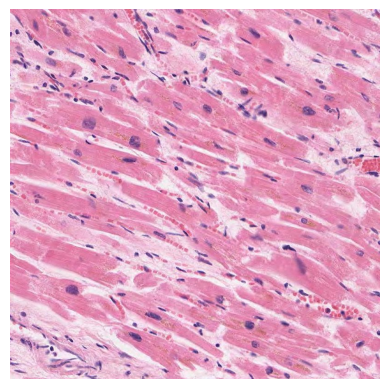

Question: what are the blue dots?
Predicted Answer: a lack of triphenyltetrazolium chloride staining in areas of necrosis


In [ ]:
def predict_answer(model, processor, image_path, question, answer_vocab, device='cuda'):
    # Load and process the image
    image = Image.open(image_path).convert("RGB").resize((224, 224))

    # Prepare the inputs for the model
    inputs = processor(images=image, text=question, return_tensors="pt", padding='max_length', truncation=True, max_length=40)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Run the model
    model.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted answer
    logits = outputs.logits
    predicted_id = logits.argmax(-1).item()
    predicted_answer = list(answer_vocab.keys())[list(answer_vocab.values()).index(predicted_id)]

    return predicted_answer

# Example usage:
image_path = '/content/tissue.jpeg'
question = "What are the blue dots?"
predicted_answer = predict_answer(model, processor, image_path, question, answer_vocab)
print(f"Question: {question}")
print(f"Predicted Answer: {predicted_answer}")


# Bleu And Meteor Score

In [ ]:
def calculate_bleu_meteor(model, processor, dataset, answer_vocab, device='cuda'):
    model.to(device)
    model.eval()
    bleu_scores = []
    meteor_scores = []
    references = []
    hypotheses = []

    # Smoothing function for BLEU score
    smoothing_fn = SmoothingFunction().method1

    # Iterate through the dataset
    for data in tqdm(dataset, desc="Evaluating"):
        image = data['image'].convert("RGB").resize((224, 224))  # Convert and resize the image
        question = data['question']
        reference_answer = data['answer']

        # Process the inputs
        inputs = processor(images=image, text=question, return_tensors="pt", padding='max_length', truncation=True, max_length=40).to(device)

        # Get the model's prediction
        with torch.no_grad():
            outputs = model(**inputs)

        # Convert logits to predicted answer
        pred_idx = outputs.logits.argmax(dim=-1).item()
        pred_answer = list(answer_vocab.keys())[list(answer_vocab.values()).index(pred_idx)]

        # Tokenize answer and predicted answer
        reference_tokens = reference_answer.split()
        hypothesis_tokens = pred_answer.split()

        # Store references and hypotheses for BLEU and METEOR calculations
        references.append(reference_tokens)
        hypotheses.append(hypothesis_tokens)

        # Calculate BLEU score for the current example
        bleu = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smoothing_fn)
        bleu_scores.append(bleu)

        # Calculate METEOR score for the current example
        meteor = meteor_score([reference_answer], pred_answer)
        meteor_scores.append(meteor)

    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    avg_meteor = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0

    return avg_bleu, avg_meteor, references, hypotheses

# Example usage:
sampled_dataset = [{'image': ann['image'], 'question': ann['question'], 'answer': ann['answer']} for ann in ds['train'][:10]]
avg_bleu, avg_meteor, references, hypotheses = calculate_bleu_meteor(model, processor, sampled_dataset, answer_vocab)
print(f"Average BLEU score: {avg_bleu}")
print(f"Average METEOR score: {avg_meteor}")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Answer vocabulary size: 2159
Average BLEU score: 0.054578450930014066
Average METEOR score: 0.15434782608695652
References: [['the', 'histone', 'subunits'], ['positively', 'charged'], ['yes'], ['in', 'the', 'canals', 'of', 'hering'], ['bile', 'duct', 'cells', 'and', 'canals', 'of', 'hering'], ['an', 'immunohistochemical', 'stain'], ['yes'], ['the', 'principal', 'cellular', 'alterations', 'that', 'characterize', 'reversible', 'cell', 'injury', 'and', 'necrosis'], ['yes'], ['no']]
Hypotheses: [['yes'], ['stroma'], ['yes'], ['stroma'], ['intervening', 'parenchyma'], ['spleen'], ['no'], ['a', 'single', 'layer', 'of', 'tall', 'columnar', 'mucin-secreting', 'epithelium', 'with', 'basally-placed', 'nuclei', 'and', 'large', 'apical', 'mucinous', 'vacuoles'], ['yes'], ['no']]
